In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

# Read data

In [2]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [3]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month

data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

### Data types and missing values

In [4]:
data.dtypes

name                                 object
url                                  object
allies killed                       float64
axis killed                         float64
allies_destroyed_tanks                int64
allies_destroyed_airplane             int64
allies_destroyed_guns                 int64
axis_destroyed_tanks                  int64
axis_destroyed_airplane               int64
axis_destroyed_guns                   int64
belligerents.allies                  object
belligerents.axis                    object
axis_leaders                         object
allies_leaders                       object
result_prop                         float64
result                               object
axis_planes                         float64
axis_guns                           float64
axis_tanks                          float64
axis_infantry                       float64
allies_planes                       float64
allies_guns                         float64
allies_tanks                    

In [5]:
cols = [
    'allies killed', 'allies_destroyed_tanks', 'allies_destroyed_guns','allies_destroyed_airplane',
    'axis killed', 'axis_destroyed_tanks', 'axis_destroyed_guns', 'axis_destroyed_airplane',
    'duration'
]

In [6]:
# data[['allies_planes', 'axis_planes']].fillna(0, inplace=True)

In [7]:
mask = data[cols].isnull().any(1)
data_kmeans = data.loc[~mask, cols]

# 1. Unsupervised learning: K-means

In [44]:
from sklearn.cluster import KMeans

In [45]:
model = KMeans(n_clusters=3)

In [46]:
labels = model.fit_predict(data_kmeans)

In [47]:
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 2 2 0 2 1 2 2 2
 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


In [48]:
data.loc[~mask, 'label'] = labels

## Visualise

In [49]:
import altair as alt
alt.renderers.enable('notebook')


RendererRegistry.enable('notebook')

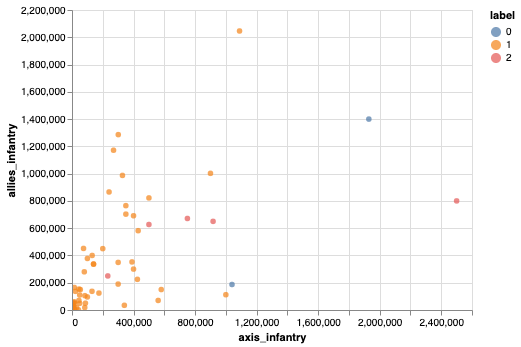

In [118]:
alt.Chart(data[~mask]).mark_circle().encode(
    color='label:N',
    x='axis_infantry', y='allies_infantry',
    tooltip=['name', 'start', 'result'] + cols).interactive()

# Scale

In [50]:
from sklearn.preprocessing import scale

In [51]:
data_scaled = scale(data_kmeans)

In [52]:
labels_scaled = model.fit_predict(data_scaled)

In [53]:
data.loc[~mask, 'label2'] = labels_scaled

In [54]:
labels_scaled

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

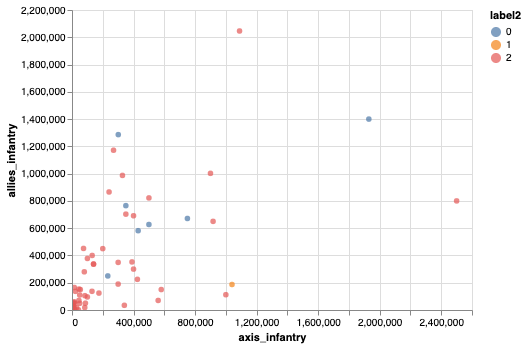

In [124]:
alt.Chart(data[~mask]).mark_circle().encode(
    color='label2:N',
    x='axis_infantry', y='allies_infantry',
    tooltip=['name', 'start', 'result'] + cols).interactive()

In [55]:
df_scaled = pd.DataFrame(data_scaled, index=data_kmeans.index, columns=data_kmeans.columns)
df_scaled['label'] = labels_scaled

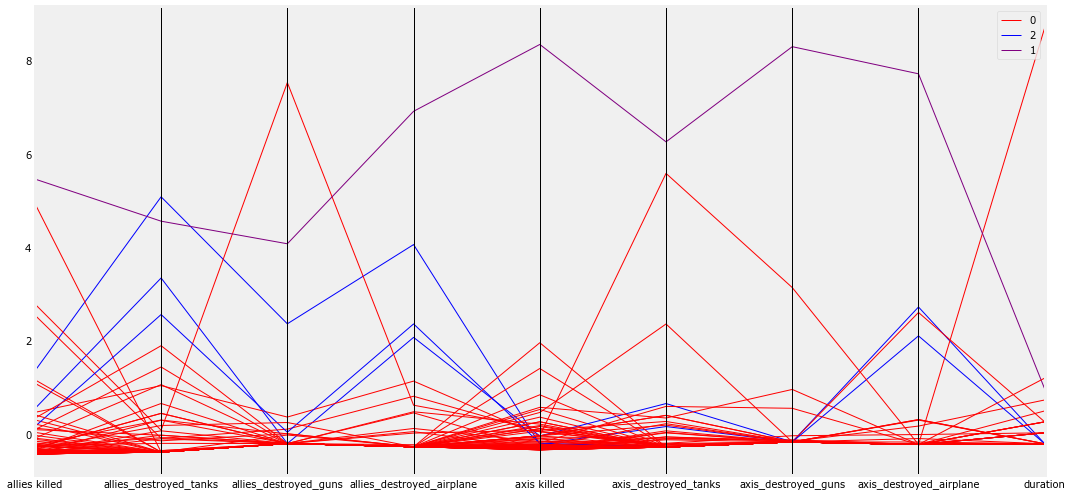

In [56]:
fig, ax = plt.subplots(figsize=(15,7))
pd.plotting.parallel_coordinates(df_scaled, class_column='label', 
                                 color=('red', 'blue', 'purple'), linewidth=1, ax=ax)
plt.tight_layout()


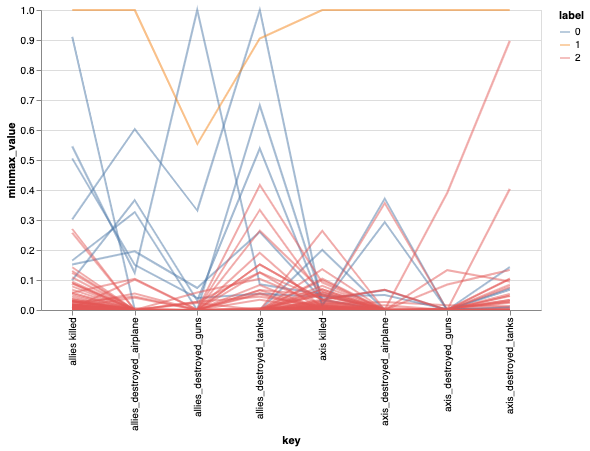

In [127]:

alt.Chart(df_scaled).transform_window(
    index='count()'
).transform_fold(
    cols
).transform_joinaggregate(
     min='min(value)',
     max='max(value)',
     groupby=['key']
).transform_calculate(
    minmax_value=(alt.datum.value-alt.datum.min)/(alt.datum.max-alt.datum.min),
    mid=(alt.datum.min+alt.datum.max)/2
).mark_line().encode(
    x='key:N',
    y='minmax_value:Q',
    color='label:N',
    detail='index:N',
    opacity=alt.value(0.5)
).properties(width=500)